In [16]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5
from terminal.Extensions.Range import Range

In [17]:
MT5.initialize()

In [20]:
from_date = datetime(2024, 6, 13, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 14, tzinfo=pytz.utc)

trades_list = None

while from_date < to_date:
    trades = mt5.copy_ticks_range("WINQ24", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE)
    if mt5.last_error()[0] == mt5.RES_S_OK and len(trades.shape) == 1:
        if trades_list is None:
            trades_list = trades
        else:
            trades_list = np.append(trades_list, trades)
    from_date += timedelta(days=1)
    del trades
    
all_trades = MT5.create_ticks_dataframe(trades_list)

In [26]:
brick_size = 25

trades_range = Range(
    brick_size, all_trades.index, all_trades["last"], all_trades["volume"]
)
ohlc = pd.DataFrame(trades_range.bricks)
ohlc.to_excel("bricks.xlsx")

In [27]:
fig = go.Figure(
    data=go.Ohlc(
        open=ohlc["open"],
        high=ohlc["high"],
        low=ohlc["low"],
        close=ohlc["close"],
    )
)

fig.update_layout(
    autosize=True,
    width=1500,
    height=600,
)

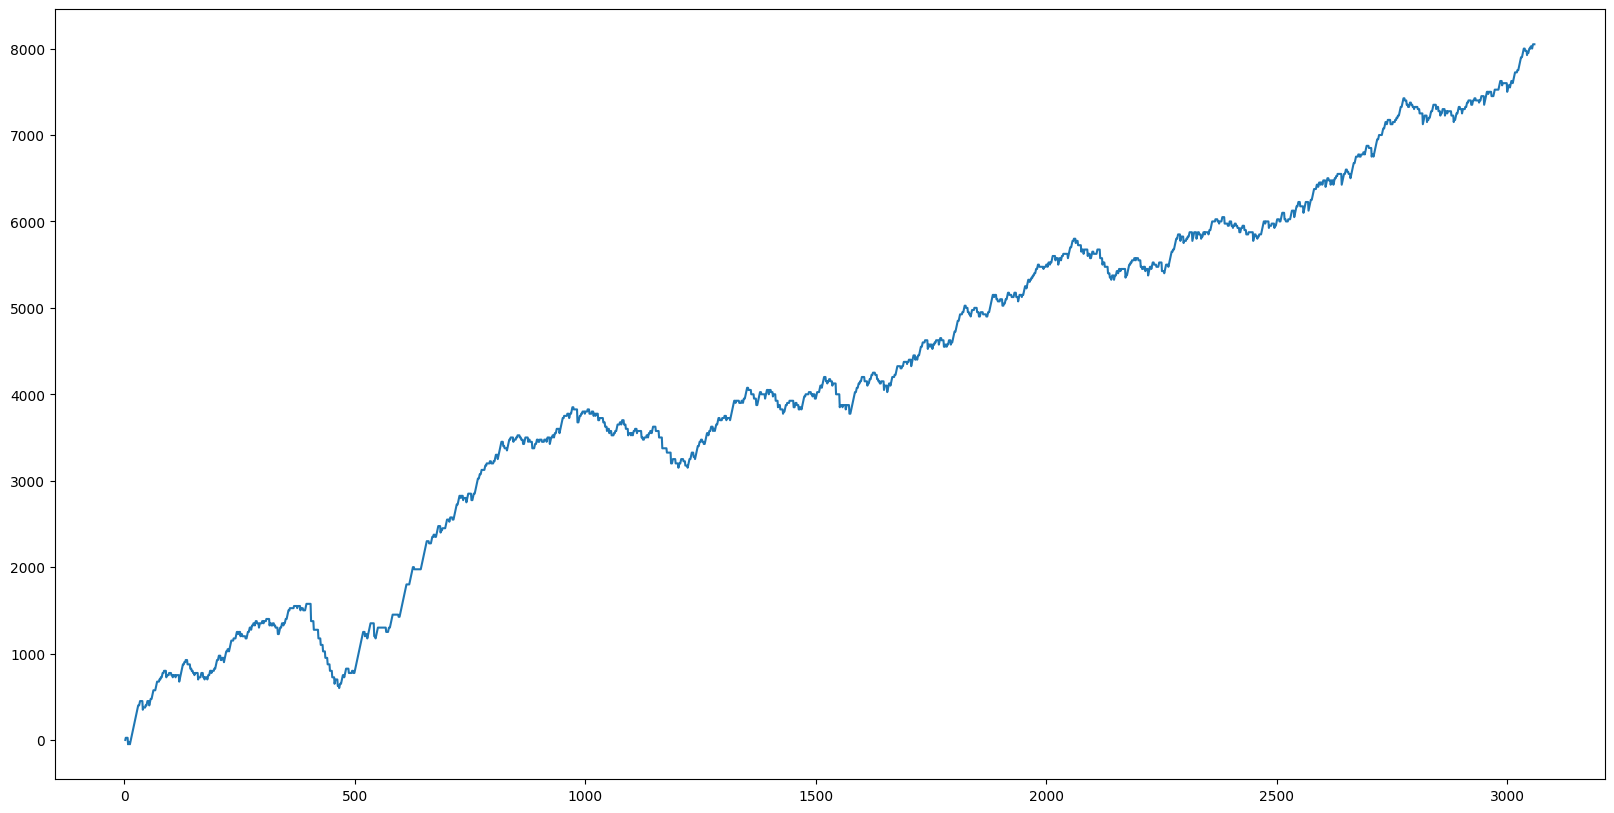

In [28]:
temp = ohlc.copy()

temp["up_up"] = np.nan
temp["down_down"] = np.nan
temp["up_down"] = np.nan
temp["down_up"] = np.nan
temp["position"] = np.nan
temp["profit"] = np.nan

temp.loc[(temp["type"] == "up") & (temp.shift(-1)["type"] == "up"), "up_up"] = 1
temp.loc[(temp["type"] == "up") & (temp.shift(-1)["type"] == "down"), "up_down"] = 1
temp.loc[(temp["type"] == "down") & (temp.shift(-1)["type"] == "down"), "down_down"] = 1
temp.loc[(temp["type"] == "down") & (temp.shift(-1)["type"] == "up"), "down_up"] = 1

position = None  # 1 = BUY, -1 = SELL
last_i = None

for i, item in temp.iterrows():
    if position is None:
        if item["type"] == "down":
            temp.loc[i, "position"] = item["close"] * -1
            position = 1  # buy

        if item["type"] == "up":
            temp.loc[i, "position"] = item["close"]
            position = -1  # sell
    elif position == -1:
        if item["type"] == "down":
            temp.loc[i, "position"] = item["close"] * 2 * -1
            position = 1
            last_i = i
    elif position == 1:
        if item["type"] == "up":
            temp.loc[i, "position"] = item["close"] * 2
            position = -1
            last_i = i

    if last_i is not None:
        temp.loc[i, "profit"] = temp.loc[: last_i]["position"].sum() - (temp.loc[last_i, "position"] / 2)

temp.loc[last_i, "position"] = temp.loc[last_i, "position"] / 2

temp["profit"].plot(figsize=(20, 10))
temp.to_excel("bricks.xlsx")